In [1]:
#importing the libraries
import pandas as pd
import os
import numpy as np
import time
import copy
import warnings
from tqdm import tqdm

#for reading and displaying images
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import preprocessing_data as prep
from dataset import ImageDataset
#Pytorch libraries and modules
import torch

from torchsummary import summary

from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader,Dataset

#torchvision for pre-trained models and augmentation
import torchvision
import torchvision.transforms as transforms
from torchvision import models

#for evaluating model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay


In [2]:
CHECKPOINT_PATH = '../model/FT_ResNet50_cp.pt'
#tao duong dan den data
train_path = '../dataset/train/'
test_path = '../dataset/test/'

BATCH_SIZE = 32
classes = ['Negative', 'Positive']

feature_extract = False
lr = 1e-3
num_classes = 2
num_epochs = 15
criterion = CrossEntropyLoss()


std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
class ImageDataset(Dataset):
    def __init__(self,csv,img_folder,transform): # 'Initialization'
        self.csv=csv
        self.transform=transform
        self.img_folder=img_folder
    
        self.image_names=self.csv[:]['file_name']# [:] lấy hết số cột số hàng của bảng
        self.labels= np.array(self.csv[:]['label']) # note kiểu mảng int đúng không?
  
    def __len__(self):  # 'Denotes the total number of samples'
        return len(self.image_names)

    def __getitem__(self,index): # 'Generates one sample of data'
    
        image=Image.open(self.img_folder + self.image_names.iloc[index]).convert('RGB')
#         print('image',image)
        image=self.transform(image)
        targets=self.labels[index]
        targets = torch.tensor(targets, dtype=torch.long) #đọc từng phần tử của mảng, chuyển từ array -> tensor; kiểu int64 tương ứng với long trong pytorch

        return image, targets # chua 1 cap

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees = 0, shear = 0.2),    
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset=ImageDataset(prep.train_set,train_path,train_transform)
val_dataset=ImageDataset(prep.val_set,train_path,test_transform) ############
test_dataset=ImageDataset(prep.test_txt,test_path,test_transform)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size= BATCH_SIZE,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)


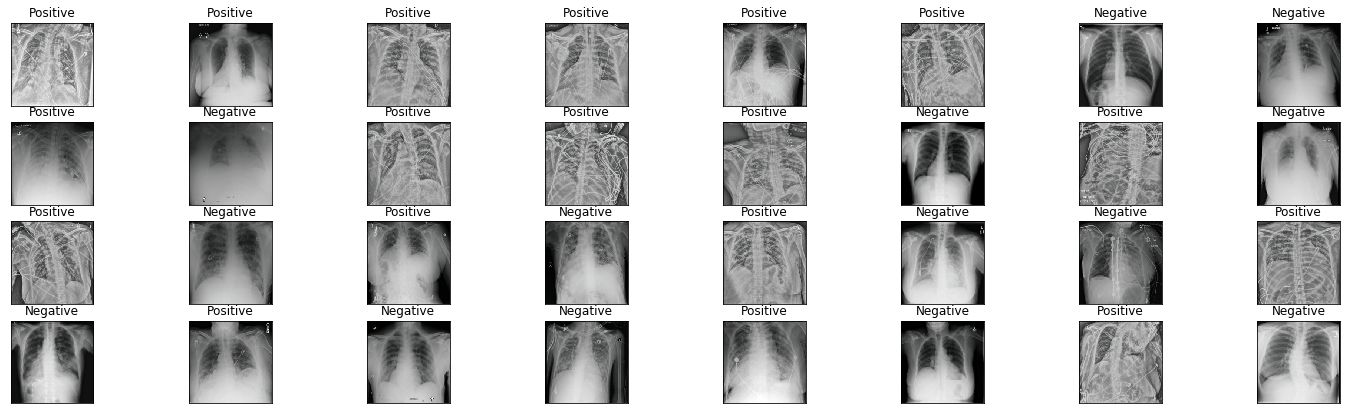

In [5]:
def imshow(inp, title=None):
    """imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    
# Get a batch of training data
image, label = next(iter(train_dataloader))
fig = plt.figure(figsize=(25, 7))

# display batch_size = 40 images
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, BATCH_SIZE/4, idx+1, xticks=[], yticks=[])
    imshow(image[idx]) # lay 1 cap co nghia la o day show anh
    ax.set_title(classes[label[idx]]) # vì đã chuyển từ nes/pos -> 0,1 -> tensor 0,1

In [6]:
def training_loop(model, optimizer, loss_list, acc_list, scheduler):
    model.to(device)
    #List to store loss to visualize
    lossli = loss_list
    accli = acc_list
    
    y_true = []
    y_pred = []
    
    valid_loss_min = np.Inf # track change in validation loss
    count = 0
    patience = 8 # nếu val_loss tăng 8 lần thì ngừng
    for epoch in range(num_epochs):
        
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for data, label in tqdm(train_dataloader):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        
            
            train_loss += loss.item()*data.size(0)
            
            _, pred = torch.max(output, 1)              
            
            train_acc += pred.eq(label).sum().item()
            
        scheduler.step() ###########
            
        ######################
        # validate the model #
        ######################
        
        model.eval()
        with torch.no_grad():
            for data, label in tqdm(val_dataloader):
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item()*data.size(0)
                
                # Calculate accuracy
                _, pred = torch.max(output, 1)
#                 y_true += target.tolist()
#                 y_pred += pred.tolist()  
                
                valid_acc +=  pred.eq(label).sum().item()
       
        # calculate average losses
        train_loss = train_loss/len(train_dataloader.dataset)
        valid_loss = valid_loss/len(val_dataloader.dataset)
        lossli.append({'epoch':epoch,'train_loss': train_loss,'valid_loss':valid_loss})
        
        train_acc = train_acc*100/len(train_dataloader.dataset)
        valid_acc = valid_acc*100/len(val_dataloader.dataset)
        accli.append({'epoch':epoch,'train_acc': train_acc,'valid_acc':valid_acc})
        
        ####################
        # Early stopping #
        ##################
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc))
        # save model if validation loss has decreased
       
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': accli,
            'loss_list': lossli,
            'loss': loss
            }, CHECKPOINT_PATH)
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            
            count = 0
            print('count = ',count)
            torch.save(model, '../model/FTResNet50.pt') #save model 
                                  
            valid_loss_min = valid_loss
        else:
            count += 1
            print('count = ',count)
            if count >= patience:
                print('Early stopping!')
   
                return lossli, accli    
           
    return lossli, accli

In [7]:
def set_parameter_requires_grad (model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
def initialize_model(num_classes, feature_extract, use_pretrained = True):
    model_ft = models.resnet152(pretrained = use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = Linear(num_ftrs, num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract = False, use_pretrained = True)

print (model_ft)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/trucloan/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [9]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = Adam(params_to_update ,lr = lr, weight_decay = lr/num_epochs)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones = [5,10], gamma=0.1, last_epoch=-1, verbose=False)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [10]:
loss_list, acc_list = [],[]

since = time.time()

loss, acc = training_loop(
    model = model_ft,
    optimizer = optimizer,
    loss_list = loss_list,
    acc_list = acc_list,
    scheduler = scheduler
)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

100%|██████████| 191/191 [01:29<00:00,  2.13it/s]


Epoch: 0 	Training Loss: 0.189124 	Validation Loss: 0.187372 
 	Training Acc: 93.176133 	Validation Acc: 92.438904
Validation loss decreased (inf --> 0.187372). Saving model ...
count =  0


100%|██████████| 191/191 [01:29<00:00,  2.14it/s]


Epoch: 1 	Training Loss: 0.118563 	Validation Loss: 0.718826 
 	Training Acc: 95.837605 	Validation Acc: 80.613416



  0%|          | 0/763 [00:00<?, ?it/s]

count =  1


100%|██████████| 191/191 [01:28<00:00,  2.15it/s]


Epoch: 2 	Training Loss: 0.117445 	Validation Loss: 0.333676 
 	Training Acc: 95.833504 	Validation Acc: 86.681975



  0%|          | 0/763 [00:00<?, ?it/s]

count =  2


100%|██████████| 191/191 [01:30<00:00,  2.12it/s]


Epoch: 3 	Training Loss: 0.104232 	Validation Loss: 0.196019 
 	Training Acc: 96.424031 	Validation Acc: 92.406101



  0%|          | 0/763 [00:00<?, ?it/s]

count =  3


100%|██████████| 191/191 [01:25<00:00,  2.24it/s]


Epoch: 4 	Training Loss: 0.096602 	Validation Loss: 0.156938 
 	Training Acc: 96.752102 	Validation Acc: 94.620305
Validation loss decreased (0.187372 --> 0.156938). Saving model ...
count =  0


100%|██████████| 191/191 [01:25<00:00,  2.24it/s]


Epoch: 5 	Training Loss: 0.065280 	Validation Loss: 0.082046 
 	Training Acc: 97.810129 	Validation Acc: 97.228145
Validation loss decreased (0.156938 --> 0.082046). Saving model ...
count =  0


100%|██████████| 191/191 [01:25<00:00,  2.23it/s]


Epoch: 6 	Training Loss: 0.056033 	Validation Loss: 0.057096 
 	Training Acc: 98.076686 	Validation Acc: 98.097425
Validation loss decreased (0.082046 --> 0.057096). Saving model ...
count =  0


100%|██████████| 191/191 [01:25<00:00,  2.25it/s]


Epoch: 7 	Training Loss: 0.051086 	Validation Loss: 0.059265 
 	Training Acc: 98.265327 	Validation Acc: 98.015417



  0%|          | 0/763 [00:00<?, ?it/s]

count =  1


100%|██████████| 191/191 [01:24<00:00,  2.26it/s]


Epoch: 8 	Training Loss: 0.047420 	Validation Loss: 0.075206 
 	Training Acc: 98.417060 	Validation Acc: 97.474168



  0%|          | 0/763 [00:00<?, ?it/s]

count =  2


100%|██████████| 191/191 [01:24<00:00,  2.27it/s]


Epoch: 9 	Training Loss: 0.046071 	Validation Loss: 0.046578 
 	Training Acc: 98.478573 	Validation Acc: 98.048220
Validation loss decreased (0.057096 --> 0.046578). Saving model ...
count =  0


100%|██████████| 191/191 [01:25<00:00,  2.24it/s]


Epoch: 10 	Training Loss: 0.037149 	Validation Loss: 0.038859 
 	Training Acc: 98.728727 	Validation Acc: 98.507463
Validation loss decreased (0.046578 --> 0.038859). Saving model ...
count =  0


100%|██████████| 191/191 [01:26<00:00,  2.21it/s]


Epoch: 11 	Training Loss: 0.034757 	Validation Loss: 0.042574 
 	Training Acc: 98.839450 	Validation Acc: 98.359849



  0%|          | 0/763 [00:00<?, ?it/s]

count =  1


100%|██████████| 191/191 [01:27<00:00,  2.18it/s]


Epoch: 12 	Training Loss: 0.034281 	Validation Loss: 0.072409 
 	Training Acc: 98.765635 	Validation Acc: 97.474168



  0%|          | 0/763 [00:00<?, ?it/s]

count =  2


100%|██████████| 191/191 [01:28<00:00,  2.16it/s]


Epoch: 13 	Training Loss: 0.034701 	Validation Loss: 0.059786 
 	Training Acc: 98.855854 	Validation Acc: 97.966213



  0%|          | 0/763 [00:00<?, ?it/s]

count =  3


100%|██████████| 191/191 [01:27<00:00,  2.18it/s]


Epoch: 14 	Training Loss: 0.030472 	Validation Loss: 0.044528 
 	Training Acc: 98.950174 	Validation Acc: 98.359849
count =  4
Training complete in 155m 33s


In [11]:
checkpoint = torch.load(CHECKPOINT_PATH)#, map_location=device)
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_list = checkpoint['loss_list']
acc_list = checkpoint['train_acc']

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


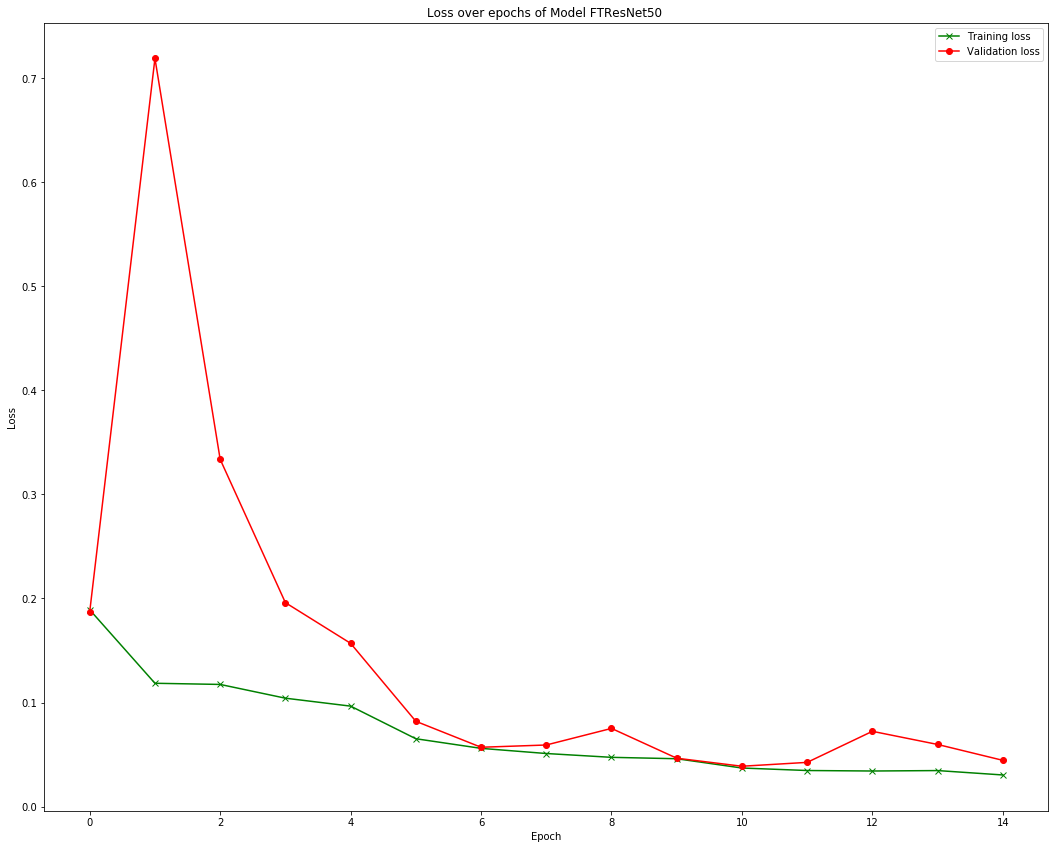

In [12]:
#ve do thi loss (train, val)
def visualize_loss (checkpoint, path_loss):
    loss = checkpoint['loss_list'] 
    train_loss = [x['train_loss'] for x in loss]
    valid_loss = [x['valid_loss'] for x in loss]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_loss, '-gx', label='Training loss')
    ax.plot(valid_loss , '-ro', label='Validation loss')
    ax.set(title="Loss over epochs of Model FTResNet50 ",
    xlabel='Epoch',
    ylabel='Loss')
    ax.legend()
    fig.show()
    plt.savefig(path_loss)
visualize_loss(checkpoint, '../report/lossFTResNet50.png')

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


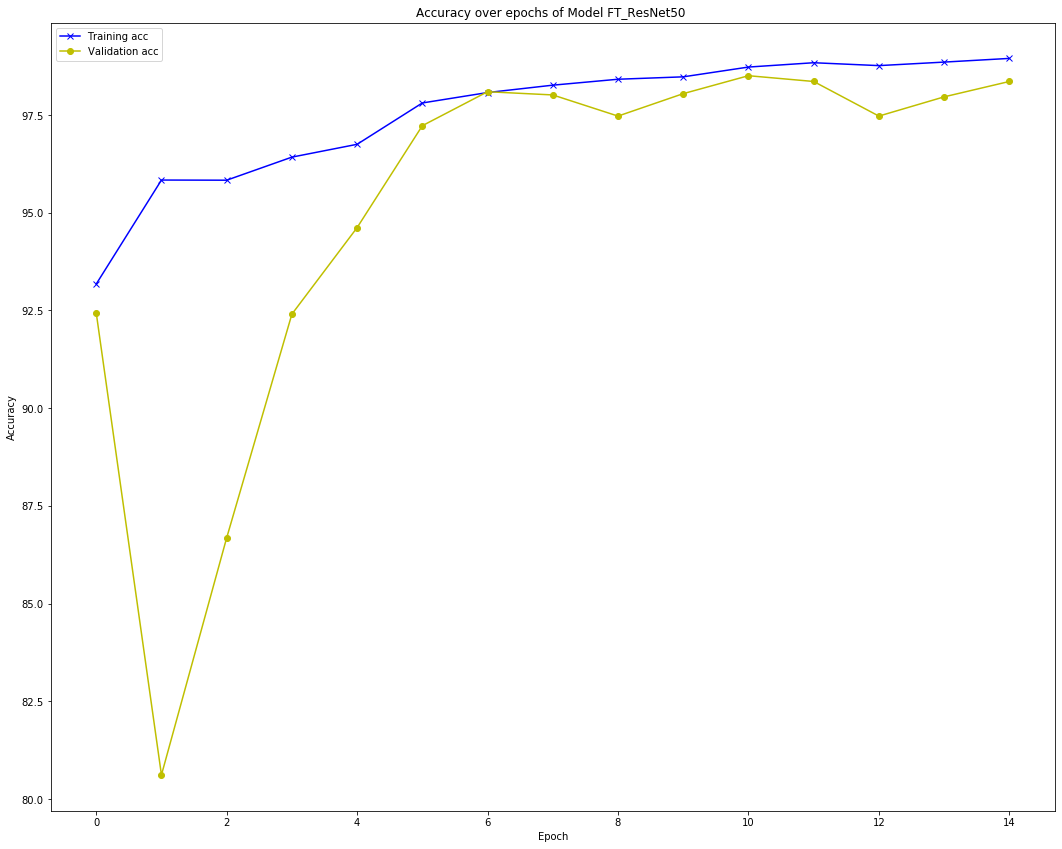

In [13]:
#ve do thi acc (train, val)
def visualize_acc (checkpoint, path_acc):
    acclist = checkpoint['train_acc'] #
    train_acc = [x['train_acc'] for x in acclist]
    valid_acc = [x['valid_acc'] for x in acclist]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_acc, '-bx', label='Training acc')
    ax.plot(valid_acc , '-yo', label='Validation acc')
    ax.set(title="Accuracy over epochs of Model FT_ResNet50 ",
    xlabel='Epoch',
    ylabel='Accuracy')
    ax.legend()
    fig.show()
    plt.savefig(path_acc)
visualize_acc(checkpoint, '../report/AccuracyFTResNet50.png')

In [14]:
#test model
def test_loop():
    with torch.no_grad():
        y_true = []
        y_pred = []
        model_ft.to(device)
        model_ft.eval()
        for data, target in test_dataloader:
            batch_size = data.size(0)
            data = data.to(device)
            target = target.to(device)
            output = model_ft(data)
            _,pred = torch.max(output, 1)
            y_true += target.tolist()
            y_pred += pred.tolist()
    return y_true, y_pred


y_true, y_pred = test_loop()
        

In [15]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.9625

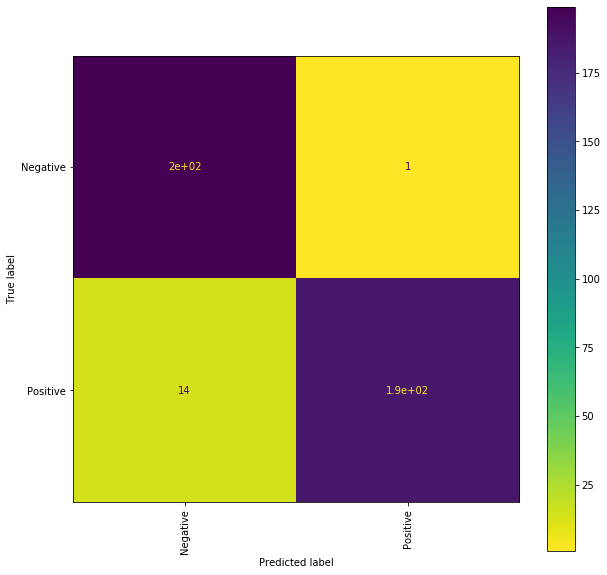

In [16]:
cnf_matrix = confusion_matrix(y_true, y_pred)
fix, ax = plt.subplots(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = classes)
disp.plot(include_values = True, cmap = 'viridis_r', ax = ax, xticks_rotation = 'vertical')
plt.savefig('../report/Matrix.png')

In [20]:
path_rp = '../report/reportFT_ResNet50_152.txt'
try:
    s = classification_report(y_true, y_pred, target_names = classes)
    with open(path_rp, mode ='x') as f:
        f.write(s)
    with open(path_rp) as f:
        print(f.read())
    f.close()
except FileExistsError:
    pass

              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96       200
    Positive       0.99      0.93      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



In [18]:
# Predict images
def img_transform(path_img):
    img = Image.open(path_img)
    imagetensor = test_transform(img).cuda()
    return imagetensor

def predict(path_img, verbose = False):
    if not verbose:
        warnings.filterwarnings('ignore')
    try:
        checks_if_model_is_loaded = type(model_ft)
    except:
        pass
    model_ft.eval()
    if verbose:
        print('Model loader ...')
    image = img_transform(path_img)
    image1 = image[None,:,:,:]
    
    with torch.no_grad():
        outputs = model_ft(image1)
        
        _,pred_int = torch.max(outputs.data, 1)
        _,top1_idx = torch.topk(outputs.data, 1, dim = 1)
        pred_idx = int(pred_int.cpu().numpy())
        if pred_idx == 0:
            pred_str = str('Negative')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
        else:
            pred_str = str('Positive')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
            
    

img: covid.jpg is: Positive


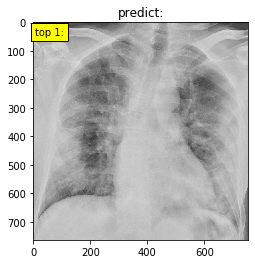

In [19]:
pred_str = str('')
path_image = '../pred/covid.jpg'

img = Image.open(path_image)
plt.imshow(img)

predict(path_image)
plt.title('predict:{}'.format(pred_str))
plt.text(5,45,'top {}:{}'.format(1,pred_str), bbox = dict(fc='yellow'))
plt.show()